<a href="https://colab.research.google.com/github/zmgy107/DGL-Learning-Notes/blob/main/Chapter_4_Graph_Data_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install  dgl -f https://data.dgl.ai/wheels/cu117/repo.html
%pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

import dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/cu117/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 MB 5.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# 4.1 DGLDataset class

DGLDataset is the base class for processing, loading and saving graph datasets defined in dgl.data. It implements the basic pipeline for processing graph data. The following flow chart shows how the pipeline works.

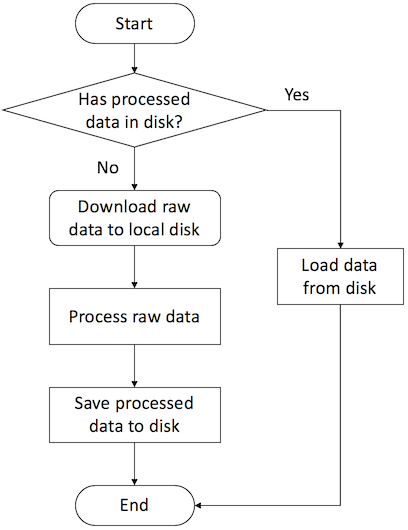

The template of MyDataset is as follows.

In [ ]:
from dgl.data import DGLDataset

class MyDataset(DGLDataset):
  """parameters:
  url:str URL to download the raw dataset
  raw_dir:str
    Specify the directory that will store the 
    download data or the directory that already 
    stores the input data
    Default:~/.dgl/
  save_dgl:str
    Directory to save the processed dataset
    Default:the value of 'raw_dir'
  force_reload:bool
    whether to reload the dataset.
    Default:False
  verbose:bool
    Whether to print out process information
  """
  def __init__(
      self,
      url=None,
      raw_dir=None,
      save_dir=None,
      force_reload=False,
      verbose=False):
    super(MyDataset,self).__init__(name='dataset_name',
                    url=url,
                    raw_dir=raw_dir,
                    save_dir=save_dir,
                    force_reload=force_reload,
                    verbose=verbose)
  
  def download(self):
    # download raw data to local disk
    pass
  
  def process(self):
    # process raw data to graphs, labels, splitting masks
    pass

  def __getitem__(self, idx):
    # get one example by index
    pass

  def __len__(self):
    # number of data examples
    pass

  def save(self):
    # save processed data to directory `self.save_path`
    pass

  def load(self):
    # load processed data from directory `self.save_path`
    pass

  def has_cache(self):
    # check whether there are processed data in `self.save_path`
    pass

DGLDataset class has abstract functions process(), __getitem__(idx) and __len__() that must be implemented in the subclass. DGL also recommends implementing saving and loading as well, since they can save significant time for processing large datasets, and there are several APIs making it easy

__Note that the purpose of DGLDataset is to provide a standard and convenient way to load graph data.__ One can store graphs, features, labels, masks and basic information about the dataset, such as number of classes, number of labels, etc. Operations such as sampling, partition or feature normalization are done outside of the DGLDataset subclass.


# 4.2 Download raw data(optional)

If a dataset is already in local disk, make sure it’s __in directory raw_dir__. If one wants to run the code anywhere without bothering to download and move data to the right directory, one can do it automatically by implementing function download().

If the dataset is a __zip file__,make MyDataset inherit from dgl.data.DGLBuiltinDataset class, which handles the zip file extraction for us.Otherwise, one needs to implement download() like in QM7bDataset:

In [ ]:
import os
from dgl.data.utils import download

def download(self):
  # path to store the file
  file_path=os.path.join(self.raw_dir,self.name+'.mat') # download .mat file to directory self.raw_dir
  # download file
  download(self.url,path=file_path)

If the file is a __.gz,.tar,.tar.gz or .tgz file__,use 

```
# extract_archive()
```
function to extract.


In [ ]:
# download a .gz file in BitcoinOTCDataset
from dgl.data.utils import download,check_sha1

def download(self):
  # path to store the file
  # make sure to use the same suffix as the original file name's
  gz_file_path=os.path.join(self.raw_dir,self.name+'.csv.gz')
  # download file
  download(self.url,path=gz_file_path)
  # check SHA-1
  if not check_sha1(gz_file_path,self._sha1_str):
    raise UserWarning('File {} is downloaded but the content hash does not match.'
    'The repo may be outdated or download may be incomplete.'
    'otherwise you can create an issue for it.'.format(self.name+'.csv.gz'))
  # extract file to directory 'self.name' under 'self.raw_dir'
  self._extract_gz(gz_file_path,self.raw_path)

Optionally, one can check SHA-1 string of the downloaded file as the example above does, in case the author changed the file in the remote server some day.

# 4.3 Process data

One can implement the data processing code in function process(), and it assumes that the raw data is located in self.raw_dir already. 

Three types of tasks in machine learning on graphs:

*  graph classification
*  node classification
*  link prediction

The section focuses on the standard way to process graphs, features and masks. It will use builtin datasets as examples and skip the implementations for building graphs from files, but add links to the detailed implementations.

## Processing Graph Classification datasets

Graph classification datasets are almost the same as most datasets in typical machine learning tasks, where __mini-batch training is used. So one can process the raw data to a list of dgl.DGLGraph objects and a list of label tensors.__ In addition, if the raw data has been split into several files, one can add a parameter split to load specific part of the data.

In [ ]:
# take QM7bDataset as example
from scipy import io
import numpy as np
import os
from dgl.data.utils import download, save_graphs, load_graphs, \
    check_sha1, deprecate_property
from dgl import backend as F
from dgl.data import DGLDataset

class QM7bDataset(DGLDataset):
  _url = 'http://deepchem.io.s3-website-us-west-1.amazonaws.com/' \
           'datasets/qm7b.mat'
  _sha1_str= '4102c744bb9d6fd7b40ac67a300e49cd87e28392'

  def __init__(self,raw_dir=None,force_reload=False,verbose=False):
    super(QM7bDataset,self).__init__(name='qm7b',
                    url=self.url,
                    raw_dir=raw_dir,
                    force_reload=force_reload,
                    verbose=verbose)
  
  def process(self):
    mat_path=self.raw_path+'.mat'
    # process data to a list of graphs and a list of labels
    self.graphs,self.label=self._load_graph(mat_path)

  def _load_graph(self, filename):
      data = io.loadmat(filename)
      labels = F.tensor(data['T'], dtype=F.data_type_dict['float32'])
      feats = data['X']
      num_graphs = labels.shape[0]
      graphs = []
      for i in range(num_graphs):
          edge_list = feats[i].nonzero()
          g = dgl_graph(edge_list)
          g.edata['h'] = F.tensor(feats[i][edge_list[0], edge_list[1]].reshape(-1, 1),
                                  dtype=F.data_type_dict['float32'])
          graphs.append(g)
      return graphs, labels
  
  def __getitem__(self,idx):
    """ Get graph and label by index
    Parameters:
    idx:int Item index

    returns:(dgl.DGLGraph,Tensor)
    """
    return self.graph[idx],self.label[idx]

  def __len__(self):
    """Number of graphs in the dataset"""
    return len(self.graphs)

One must implement \__getitem__(idx) and \__len__() for iteration. DGL recommends making \__getitem__(idx) return a tuple (graph, label) as above.

One can also __add properties__ to the class to __indicate some useful information__ of the dataset.

In [ ]:
@property
def num_tasks(self):
  # indicate the total number of prediction tasks in multi_task dataset
  """Number of labels for each graph, i.e. number of prediction tasks."""
  return 14

After all these coding, one can finally use QM7bDataset as follows:

In [ ]:
import dgl
import torch

from dgl.dataloading import GraphDataLoader

# load data
dataset=QM7bDataset()
num_tasks=dataset.num_tasks

# create dataloader
dataloader=GraphDataLoader(dataset,batch_size=1,shuffle=True)

# train
for epoch in range(100):
  for g,labels in dataloader:
    # training code here
    pass

FileNotFoundError: ignored

more examples of graph classification datasets:
*  gindataset
*  minigcdataset
*  qm7bdata
*  tudata

## Processing Node Classification datasets

Different from graph classification, node classification is typically on a single graph. As such, splits of the dataset are on the nodes of the graph. DGL recommends using node masks to specify the splits.

In addition, DGL recommends re-arrange the nodes and edges so that nodes near to each other have IDs in a close range. The procedure could improve the locality to access a node’s neighbors, which may benefit follow-up computation and analysis conducted on the graph. DGL provides an API called 
``` 
dgl.reorder_graph() 

``` 
for this purpose. 

In [ ]:
from dgl.data import DGLBuiltinDataset
from dgl.data.utils import _get_dgl_url

class CitationGraphDataset(DGLBuiltinDataset):
  _urls={
      'cora_v2':'dataset/core_v2.zip',
      'citiseer':'dataset/citeseer.zip',
      'pubmed':'dataset/pubmed.zip',
  }

  def __init__(self,name,raw_dir=None,force_reload=False,verbose=True):
    assert name.lower() in ['cora','citeseer','pubmed']
    if name.lower()=='cora':
      name='cora_v2'
    url=_get_dgl_url(self._urls[name])
    super(CitationGraphDataset,self).__init__(
        name,
        url=url,
        raw_dir=raw_dir,
        force_reload=force_reload,
        verbose=verbose)
    
  def process(self):
    # skip some processing code
    # ===data processing skipped===

    # build graph
    g=dgl.graph(graph)
    # splitting masks
    g.ndata['train_mask']=train_mask
    g.ndata['val_mask']=val_mask
    g.ndata['test_mask']=test_mask
    # node labels
    # node labels
    g.ndata['label']=torch.tensor(labels)
    # node features
    g.ndata['feat']=torch.tensor(_preprocess_features(feature),
                  dtype=F.data_type_dict['float32'])
    self._num_tasks=onehot_labels.shape[1]
    self._labels=labels
    # reorder graph to obtain better locality.
    self._g=dgl.reorder_graph(g)
  
  def __getitem__(self,idx):
    assert idx==0,"This dataset has only one graph"
    return self._g

  def _len_(self):
    return 1

For brevity, this section skips some code in process() to highlight the key part for processing node classification dataset: splitting masks. Node features and node labels are stored in g.ndata. For detailed implementation, please refer to CitationGraphDataset source code.

Note that the implementations of __getitem__(idx) and __len__() are changed as well, since there is often only one graph for node classification tasks. The masks are bool tensors in PyTorch and TensorFlow, and float tensors in MXNet.

In [ ]:
# use a subclass of CitationGraphDataset,dgl.data.CitesserGraphDataset

# Load data
dataset=CiteseerGraphDataset(raw_dir='')
graph=dataset[0]

# get split masks
train_mask=graph.ndata['train_mask']
val_mask=graph.ndata['val_mask']
test_mask=graph.ndata['test_mask']

# get node feature
feats=graph.ndata['feat']

# get labels
labels=graph.ndata['label']

## Processing dataset for Link Prediction datasets

The processing of link prediction datasets is similar to that for node classification’s, there is often one graph in the dataset.

The section uses builtin dataset KnowledgeGraphDataset as an example, and still skips the detailed data processing code to highlight the key part for processing link prediction datasets:

In [ ]:
# example for creating link prediction datasets
class KnowledgeGraphDataset(DGLBuiltinDataset):
  def __init__(self,name,reverse=True,raw_dir=None,force_reload=False,verbose=True):
    self.name=name
    self.reverse=reverse
    url=_get_dgl_url('dataset/')+'{}.tgz'.format(name)
    super(KnowledgeGraphDataset,self).__init__(name,
                          url=url,
                          raw_dir=raw_dir,
                          force_reload=force_reload,
                          verbose=verbose)
  
  def process(self):
    # skip some process code
    # ==data processing skipped==

    # splitting mask
    g.edata['train_mask']=train_mask
    g.edata['val_mask']=val_mask
    g.edata['test_mask']=test_mask
    # edge type
    g.edata['etype']=etype
    # node type
    g.ndata['ntype']=ntype
    self._g=g

  def __getitem__(self,idx):
    assert idx==0,"This dataset has only one graph"
    return self._g
  
  def __len__(self):
    return 1

In [ ]:
# use a subclass of KnowledgeGraphDataset, dgl.data.FB15k237Dataset

from dgl.data import FB15k237Dataset

# load data
dataset=FB15k237Dataset()
graph=dataset[0]

# get training mask
train_mask=graph.edata['train_mask']
train_inx=torch.nonzero(train_mask,as_tuple=Flase).squeeze()
src,dst=graph.edges(train_idx)
# get edge types in training set
rel=graph.edata['etype'][train_idx]


# 4.5 Save and load data

DGL recommends implementing saving and loading functions to cache the processed data in local disk. This saves a lot of data processing time in most cases. DGL provides four functions to make things simple:

*  dgl.save_graphs() and dgl.load_graphs(): save/load DGLGraph objects and labels to/from local disk.

*  dgl.data.utils.save_info() and dgl.data.utils.load_info(): save/load useful information of the dataset (python dict object) to/from local disk.

In [ ]:
# example to show how to save and load a list of graphs and dataset information
import os
from dgl import save_graphs,load_graphs
from dgl.data.utils import makedirs,save_info,load_info

def save(self):
  # save graphs and labels
  graph_path=os.path.join(self.save_path,self.mode+'_dgl_graph.bin')
  save_graph(graph_path,self.graphs,{'labels':self.labels})
  # save other information in python dict
  info_path=os.path.join(self.save_path,self.mode+'_info.pkl')
  save_info(info_path,{'num_classes':self.num_classes})

def load(self):
    # load processed data from directory `self.save_path`
    graph_path = os.path.join(self.save_path, self.mode + '_dgl_graph.bin')
    self.graphs, label_dict = load_graphs(graph_path)
    self.labels = label_dict['labels']
    info_path = os.path.join(self.save_path, self.mode + '_info.pkl')
    self.num_classes = load_info(info_path)['num_classes']

def has_cache(self):
    # check whether there are processed data in `self.save_path`
    graph_path = os.path.join(self.save_path, self.mode + '_dgl_graph.bin')
    info_path = os.path.join(self.save_path, self.mode + '_info.pkl')
    return os.path.exists(graph_path) and os.path.exists(info_path)

Note that there are cases not suitable to save processed data. For example, in the builtin dataset GDELTDataset, the processed data is quite large, so it’s more effective to process each data example in __getitem__(idx).

## Loading OGB datasets using obg package

Open Graph Benchmark (OGB) is a collection of benchmark datasets. The official OGB package ogb provides APIs for downloading and processing OGB datasets into dgl.data.DGLGraph objects. The section introduce their basic usage here.

First install ogb package using pip:
```
pip install ogb
```

In [ ]:
# example to show how to load datasets for Graph Property Prediction tasks.
# Load Graph Property Prediction datasets in OGB
import dgl
import torch
from ogb.graphproppred import DglGraphPropPredDataset
from dgl.dataloading import GraphDataLoader


def _collate_fn(batch):
    # batch is a list of tuple (graph, label)
    graphs = [e[0] for e in batch]
    g = dgl.batch(graphs)
    labels = [e[1] for e in batch]
    labels = torch.stack(labels, 0)
    return g, labels

# load dataset
dataset = DglGraphPropPredDataset(name='ogbg-molhiv')
split_idx = dataset.get_idx_split()
# dataloader
train_loader = GraphDataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True, collate_fn=_collate_fn)
valid_loader = GraphDataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False, collate_fn=_collate_fn)
test_loader = GraphDataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False, collate_fn=_collate_fn)

Loading Node Property Prediction datasets is similar, but note that there is only one graph object in this kind of dataset

In [ ]:
# Load Node Property Prediction datasets in OGB
from ogb.nodeproppred import DglNodePropPredDataset

dataset = DglNodePropPredDataset(name='ogbn-proteins')
split_idx = dataset.get_idx_split()

# there is only one graph in Node Property Prediction datasets
g, labels = dataset[0]
# get split labels
train_label = dataset.labels[split_idx['train']]
valid_label = dataset.labels[split_idx['valid']]
test_label = dataset.labels[split_idx['test']]

Link Property Prediction datasets also contain one graph per dataset.

In [ ]:
# Load Link Property Prediction datasets in OGB
from ogb.linkproppred import DglLinkPropPredDataset

dataset = DglLinkPropPredDataset(name='ogbl-ppa')
split_edge = dataset.get_edge_split()

graph = dataset[0]
print(split_edge['train'].keys())
print(split_edge['valid'].keys())
print(split_edge['test'].keys())

# 4.6 Loading data from CSV files

Comma Separated Value (CSV) is a widely used data storage format. DGL provides CSVDataset for loading and parsing graph data stored in CSV format.

To create a CSVDataset object:
```
import dgl
ds=dgl.data.CSVDataset('/path/to/dataset')
```

The returned ds object is a standard DGLDataset. For example, one can get graph samples using __getitem__ as well as node/edge features using ndata/edata.

In [ ]:
# A demonstration of how to use the loaded dataset. The feature names
# may vary depending on the CSV contents.
g = ds[0] # get the graph
label = g.ndata['label']
feat = g.ndata['feat']

## Data folder structure

```
/path/to/dataset/
|-- meta.yaml     # metadata of the dataset
|-- edges_0.csv   # edge data including src_id, dst_id, feature, label and so on
|-- ...           # you can have as many CSVs for edge data as you want
|-- nodes_0.csv   # node data including node_id, feature, label and so on
|-- ...           # you can have as many CSVs for node data as you want
|-- graphs.csv    # graph-level features
```
Node/edge/graph-level data are stored in CSV files. meta.yaml is a metadata file specifying where to read nodes/edges/graphs data and how to parse them to construct the dataset object. A minimal data folder contains one meta.yaml and two CSVs, one for node data and one for edge data, in which case the dataset contains only a single graph with no graph-level data.

## Dataset of a single feature-less graph

When the dataset contains only one graph with no node or edge features, there need only three files in the data folder: meta.yaml, one CSV for node IDs and one CSV for edges:

```
./mini_featureless_dataset/
|-- meta.yaml
|-- nodes.csv
|-- edges.csv
```
meta.yaml contains the following information:
```
dataset_name: mini_featureless_dataset
edge_data:
- file_name: edges.csv
node_data:
- file_name: nodes.csv
```
nodes.csv lists the node IDs under the node_id field:
```
node_id
0
1
2
3
4
```
edges.csv lists all the edges in two columns (src_id and dst_id) specifying the source and destination node ID of each edge:
```
src_id,dst_id
4,4
4,1
3,0
4,1
4,0
1,2
1,3
3,3
1,1
4,1
```
After loaded, the dataset has one graph without any features:


In [ ]:
import dgl
dataset = dgl.data.CSVDataset('./mini_featureless_dataset')
g = dataset[0]  # only one graph
print(g)

__Note__:Non-integer node IDs are allowed. When constructing the graph, CSVDataset will map each raw ID to an integer ID starting from zero. If the node IDs are already distinct integers from 0 to num_nodes-1, no mapping is applied.

__Note__:Edges are always directed. To have both directions, add reversed edges in the edge CSV file or use AddReverse to transform the loaded graph.

## Dataset of a single graph with features and labels

When the dataset contains a single graph with node or edge features and labels, there still need only three files in the data folder: meta.yaml, one CSV for node IDs and one CSV for edges:
```
./mini_feature_dataset/
|-- meta.yaml
|-- nodes.csv
|-- edges.csv
```
meta.yaml:
```
dataset_name: mini_feature_dataset
edge_data:
- file_name: edges.csv
node_data:
- file_name: nodes.csv
```
edges.csv with five synthetic edge data (label, train_mask, val_mask, test_mask, feat):
```
src_id,dst_id,label,train_mask,val_mask,test_mask,feat
4,0,2,False,True,True,"0.5477868606453535, 0.4470617033458436, 0.936706701616337"
4,0,0,False,False,True,"0.9794634290792008, 0.23682038840665198, 0.049629338970987646"
0,3,1,True,True,True,"0.8586722047523594, 0.5746912787380253, 0.6462162561249654"
0,1,2,True,False,False,"0.2730008213674695, 0.5937484188166621, 0.765544096939567"
0,2,1,True,True,True,"0.45441619816038514, 0.1681403185591509, 0.9952376085297715"
0,0,0,False,False,False,"0.4197669213305396, 0.849983324532477, 0.16974127573016262"
2,2,1,False,True,True,"0.5495035052928215, 0.21394654203489705, 0.7174910641836348"
1,0,2,False,True,False,"0.008790817766266334, 0.4216530595907526, 0.529195480661293"
3,0,0,True,True,True,"0.6598715708878852, 0.1932390907048961, 0.9774471538377553"
4,0,1,False,False,False,"0.16846068931179736, 0.41516080644186737, 0.002158116134429955"
```
nodes.csv with five synthetic node data (label, train_mask, val_mask, test_mask, feat):

```
node_id,label,train_mask,val_mask,test_mask,feat
0,1,False,True,True,"0.07816474278491703, 0.9137336384979067, 0.4654086994009452"
1,1,True,True,True,"0.05354099924658973, 0.8753101998792645, 0.33929432608774135"
2,1,True,False,True,"0.33234211884156384, 0.9370522452510665, 0.6694943496824788"
3,0,False,True,False,"0.9784264442230887, 0.22131880861864428, 0.3161154827254189"
4,1,True,True,False,"0.23142237259162102, 0.8715767748481147, 0.19117861103555467"
```
After loaded, the dataset has one graph. Node/edge features are stored in ndata and edata with the same column names. The example demonstrates how to specify a vector-shaped feature using comma-separated list enclosed by double quotes "...".



In [ ]:
import dgl
dataset = dgl.data.CSVDataset('./mini_feature_dataset')
g = dataset[0]  # only one graph
print(g)

__Note__:By default, CSVDatatset assumes all feature data to be numerical values (e.g., int, float, bool or list) and missing values are not allowed. Users could provide custom data parser for these cases.

## Dataset of a single heterogeneous graph

One can specify multiple node and edge CSV files (each for one type) to represent a heterogeneous graph. Here is an example data with two node types and two edge types:

```
./mini_hetero_dataset/
|-- meta.yaml
|-- nodes_0.csv
|-- nodes_1.csv
|-- edges_0.csv
|-- edges_1.csv
```
The meta.yaml specifies the node type name (using ntype) and edge type name (using etype) of each CSV file. The edge type name is a string triplet containing the source node type name, relation name and the destination node type name.

```
dataset_name: mini_hetero_dataset
edge_data:
- file_name: edges_0.csv
  etype: [user, follow, user]
- file_name: edges_1.csv
  etype: [user, like, item]
node_data:
- file_name: nodes_0.csv
  ntype: user
- file_name: nodes_1.csv
  ntype: item
```

The node and edge CSV files follow the same format as in homogeneous graphs. Here are some synthetic data for demonstration purposes:

edges_0.csv and edges_1.csv:

```
src_id,dst_id,label,feat
4,4,1,"0.736833152378035,0.10522806046048205,0.9418796835016118"
3,4,2,"0.5749339182767451,0.20181320245665535,0.490938012147181"
1,4,2,"0.7697294432580938,0.49397782380750765,0.10864079337442234"
0,4,0,"0.1364240150959487,0.1393107840629273,0.7901988878812207"
2,3,1,"0.42988138237505735,0.18389137408509248,0.18431292077750894"
0,4,2,"0.8613368738351794,0.67985810014162,0.6580438064356824"
2,4,1,"0.6594951663841697,0.26499036865016423,0.7891429392727503"
4,1,0,"0.36649684241348557,0.9511783938523962,0.8494919263589972"
1,1,2,"0.698592283371875,0.038622249776255946,0.5563827995742111"
0,4,1,"0.5227112950269823,0.3148264185956532,0.47562693094002173"
```

nodes_0.csv and nodes_1.csv:

```
node_id,label,feat
0,2,"0.5400687466285844,0.7588441197954202,0.4268254673041745"
1,1,"0.08680051341900807,0.11446843700743892,0.7196969604886617"
2,2,"0.8964389655603473,0.23368113896545695,0.8813472954005022"
3,1,"0.5454703921677284,0.7819383771535038,0.3027939452162367"
4,1,"0.5365210052235699,0.8975240205792763,0.7613943085507672"
```

After loaded, the dataset has one heterograph with features and labels:


In [ ]:
import dgl
dataset = dgl.data.CSVDataset('./mini_hetero_dataset')
g = dataset[0]  # only one graph
print(g)
g.nodes['user'].data
g.edges['like'].data

## Dataset of multiple graphs

When there are multiple graphs, one can include an additional CSV file for storing graph-level features. Here is an example:

```
./mini_multi_dataset/
|-- meta.yaml
|-- nodes.csv
|-- edges.csv
|-- graphs.csv
```
Accordingly, the meta.yaml should include an extra graph_data key to tell which CSV file to load graph-level features from.
```
dataset_name: mini_multi_dataset
edge_data:
- file_name: edges.csv
node_data:
- file_name: nodes.csv
graph_data:
  file_name: graphs.csv
```
To distinguish nodes and edges of different graphs, the node.csv and edge.csv must contain an extra column graph_id:

edges.csv:
```
graph_id,src_id,dst_id,feat
0,0,4,"0.39534097273254654,0.9422093637539785,0.634899790318452"
0,3,0,"0.04486384200747007,0.6453746567017163,0.8757520744192612"
0,3,2,"0.9397636966928355,0.6526403892728874,0.8643238446466464"
0,1,1,"0.40559906615287566,0.9848072295736628,0.493888090726854"
0,4,1,"0.253458867276219,0.9168191778828504,0.47224962583565544"
0,0,1,"0.3219496197945605,0.3439899477636117,0.7051530741717352"
0,2,1,"0.692873149428549,0.4770019763881086,0.21937428942781778"
0,4,0,"0.620118223673067,0.08691420300562658,0.86573472329756"
0,2,1,"0.00743445923710373,0.5251800239734318,0.054016385555202384"
0,4,1,"0.6776417760682221,0.7291568018841328,0.4523600060547709"
1,1,3,"0.6375445528248924,0.04878384701995819,0.4081642382536248"
1,0,4,"0.776002616178397,0.8851294998284638,0.7321742043493028"
1,1,0,"0.0928555079874982,0.6156748364694707,0.6985674921582508"
1,0,2,"0.31328748118329997,0.8326121496142408,0.04133991340612775"
1,1,0,"0.36786902637778773,0.39161865931662243,0.9971749359397111"
1,1,1,"0.4647410679872376,0.8478810655406659,0.6746269314422184"
1,0,2,"0.8117650553546695,0.7893727601272978,0.41527155506593394"
1,1,3,"0.40707309111756307,0.2796588354307046,0.34846782265758314"
1,1,0,"0.18626464175355095,0.3523777809254057,0.7863421810531344"
1,3,0,"0.28357022069634585,0.13774964202156292,0.5913335505943637"
```
nodes.csv:
```
graph_id,node_id,feat
0,0,"0.5725330322207948,0.8451870383322376,0.44412796119211184"
0,1,"0.6624186423087752,0.6118386331195641,0.7352138669985214"
0,2,"0.7583372765843964,0.15218126307872892,0.6810484348765842"
0,3,"0.14627522432017592,0.7457985352827006,0.1037097085190507"
0,4,"0.49037522512771525,0.8778998699783784,0.0911194482288028"
1,0,"0.11158102039672668,0.08543289788089736,0.6901745368284345"
1,1,"0.28367647637469273,0.07502571020414439,0.01217200152200748"
1,2,"0.2472495901894738,0.24285506608575758,0.6494437360242048"
1,3,"0.5614197853127827,0.059172654879085296,0.4692371689047904"
1,4,"0.17583413999295983,0.5191278830882644,0.8453123358491914"
```
The graphs.csv contains a graph_id column and arbitrary number of feature columns. The example dataset here has two graphs, each with a feat and a label graph-level data.

```
graph_id,feat,label
0,"0.7426272601929126,0.5197462471155317,0.8149104951283953",0
1,"0.534822233529295,0.2863627767733977,0.1154897249106891",0
```
After loaded, the dataset has multiple homographs with features and labels:



In [ ]:
import dgl
dataset = dgl.data.CSVDataset('./mini_multi_dataset')
print(len(dataset))
graph0, data0 = dataset[0]
print(graph0)
print(data0)
graph1, data1 = dataset[1]
print(graph1)
print(data1)

## Custom Data Parser

By default, CSVDataset assumes that all the stored node-/edge-/graph- level data are numerical values. Users can provide custom DataParser to CSVDataset to handle more complex data type. A DataParser needs to implement the __call__ method which takes in the pandas.DataFrame object created from CSV file and should return a dictionary of parsed feature data. The parsed feature data will be saved to the ndata and edata of the corresponding DGLGraph object, and thus must be tensors or numpy arrays. Below shows an example DataParser which converts string type labels to integers:

Given a dataset as follows,
```
./customized_parser_dataset/
|-- meta.yaml
|-- nodes.csv
|-- edges.csv
```

meta.yaml:
```
dataset_name: customized_parser_dataset
edge_data:
- file_name: edges.csv
node_data:
- file_name: nodes.csv
```
edges.csv:
```
src_id,dst_id,label
4,0,positive
4,0,negative
0,3,positive
0,1,positive
0,2,negative
0,0,positive
2,2,negative
1,0,positive
3,0,negative
4,0,positive
```
nodes.csv:
```
node_id,label
0,positive
1,negative
2,positive
3,negative
4,positive
```
To parse the string type labels, one can define a DataParser class as follows:


In [ ]:
import numpy as np
import pandas as pd

class MyDataParser:
    def __call__(self, df: pd.DataFrame):
        parsed = {}
        for header in df:
            if 'Unnamed' in header:  # Handle Unnamed column
                print("Unamed column is found. Ignored...")
                continue
            dt = df[header].to_numpy().squeeze()
            if header == 'label':
                dt = np.array([1 if e == 'positive' else 0 for e in dt])
            parsed[header] = dt
        return parsed

Create a CSVDataset using the defined DataParser:

In [ ]:
import dgl
dataset = dgl.data.CSVDataset('./customized_parser_dataset',
                              ndata_parser=MyDataParser(),
                              edata_parser=MyDataParser())
print(dataset[0].ndata['label'])
print(dataset[0].edata['label'])

__Note__:To specify different DataParsers for different node/edge types, pass a dictionary to ndata_parser and edata_parser, where the key is type name (a single string for node type; a string triplet for edge type) and the value is the DataParser to use.

## Full YAML Specification

CSVDataset allows more flexible control over the loading and parsing process. For example, one can change the ID column names via meta.yaml. The example below lists all the supported keys.

```
version: 1.0.0
dataset_name: some_complex_data
separator: ','                   # CSV separator symbol. Default: ','
edge_data:
- file_name: edges_0.csv
  etype: [user, follow, user]
  src_id_field: src_id           # Column name for source node IDs. Default: src_id
  dst_id_field: dst_id           # Column name for destination node IDs. Default: dst_id
- file_name: edges_1.csv
  etype: [user, like, item]
  src_id_field: src_id
  dst_id_field: dst_id
node_data:
- file_name: nodes_0.csv
  ntype: user
  node_id_field: node_id         # Column name for node IDs. Default: node_id
- file_name: nodes_1.csv
  ntype: item
  node_id_field: node_id         # Column name for node IDs. Default: node_id
graph_data:
  file_name: graphs.csv
  graph_id_field: graph_id       # Column name for graph IDs. Default: graph_id
```
## Top-level

At the top level, only 6 keys are available:

*  version: Optional. String. It specifies which version of meta.yaml is used. More feature may be added in the future.
*  dataset_name: Required. String. It specifies the dataset name.
*  separator: Optional. String. It specifies how to parse data in CSV files. Default: ','.
*  edge_data: Required. List of EdgeData. Meta data for parsing edge CSV files.
*  node_data: Required. List of NodeData. Meta data for parsing node CSV files.
*  graph_data: Optional. GraphData. Meta data for parsing the graph CSV file.

EdgeData

*  file_name: Required. String. The CSV file to load data from.
*  etype: Optional. List of string. Edge type name in string triplet: [source node type, relation type, destination node type].
*  src_id_field: Optional. String. Which column to read for source node IDs. Default: src_id.
*  dst_id_field: Optional. String. Which column to read for destination node IDs. Default: dst_id.

NodeData

*  file_name: Required. String. The CSV file to load data from.
*  ntype: Optional. String. Node type name.
*  node_id_field: Optional. String. Which column to read for node IDs. Default: node_id.

GraphData

*  file_name: Required. String. The CSV file to load data from.
*  graph_id_field: Optional. String. Which column to read for graph IDs. Default: graph_id.